In [1]:
import saopaulo.sp_grid as gr
import bikescience.distributions as dist
from bikescience.slope import plot_slope, plot_slopes, split_route
from shapely.geometry import LineString
import ast
import numpy as np

import folium
import pandas as pd
import geopandas as gpd
from statistics import stdev
from ipywidgets import interact_manual, widgets, fixed
from IPython.core.display import display, HTML, clear_output
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import warnings
import requests
import os
warnings.simplefilter('ignore')
import time
import scipy.stats as st
zone_shp = gpd.read_file('../data/sao-paulo/od/shapes/Zonas_2017_region.shp')
zone_shp.crs = {'init': 'epsg:31983'}  
zone_shp.to_crs(epsg='4326', inplace=True)

#od_routes = pd.read_csv('../data/sao-paulo/od/routes.csv')
od_routes_sp = gpd.read_file('../data/sao-paulo/od/routes/bike_routes_in_sp.shp')
od_routes_sp.crs = {'init': 'epsg:4326'}

#od_routes_all = gpd.read_file('../data/sao-paulo/od/routes/bike_routes_all.shp')
#od_routes_all.crs = {'init': 'epsg:4326'}

od_routes_sp['length'] = od_routes_sp['geometry'].length
#display(od_routes_sp.sort_values('length').tail(5))

route_stretchs_size = 500 #meters

/home/pedro/.local/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
sizes = [5000, 1000, 500, 200, 100, 'line']
def show_slopes_widgets( routes, title = "Declividade das rotas de viagens de bicicleta da OD 2017"):
    # transform the lambda code in string, so we can pass as a string widget
    #pass the parameters as hidden widgets
    im = interact_manual(
        show_slopes,
        routes = fixed(routes),
        title = fixed(title),
        absolute = widgets.Checkbox(value=False, description = 'Valor absoluto'),
        size = widgets.Dropdown(options = sizes, value=500,
                                 description = 'Trechos (em metros)')
    )
    im.widget.children[2].description = 'Gerar o mapa'
    
def show_slopes(routes, title, absolute, size):
    fmap = gr.map_around_sp(the_grid=None,zoom=11,plot_grid=False)
    folium.GeoJson(zone_shp.loc[zone_shp['NumeroMuni'] == 36],
                   style_function = lambda x: {'color': 'black', 'weight': 0.5, 'fillOpacity': 0},
                   name='Zonas', control=True).add_to(fmap)
    plot_slopes(fmap, routes, size, absolute, title)
    folium.LayerControl().add_to(fmap)
    file = 'maps/slopes_' + str(size) + '.html'
    fmap.save(file)
    display(HTML('Salvo em <a href="' + file + '" target="_blank">' + file + '</a>'))
    display(fmap)

In [3]:
show_slopes_widgets(od_routes_sp['geometry'])

interactive(children=(Checkbox(value=False, description='Valor absoluto'), Dropdown(description='Trechos (em m…

In [12]:
genders = {1: 'm', 2: 'f', 'm': 'm', 'f': 'f'}

distribs = {
    'distance_m':    (st.invweibull, (1.9624908421440037, -1358.5912359607478, 3558.697966253873)),
    'distance_f':    (st.johnsonsu,  (-1.6348791801316755, 0.8220563043475115, 599.1107992085285, 401.86433888871386)),
    'age_m':         (st.gausshyper, (5.279282420419191, 9.427435120845999, 1.7042238760442698, -0.6290314796750072, -9.35105798112198, 113.89907371835868)),
    'age_f':         (st.loggamma,   (897.3569843061273, -2332.923603808461, 347.1732584129129)),
    'slope_0_m':     (st.halfgennorm, (0.5938931306470469, -0.24400150361767925, 331.4710613095754)) ,
    'slope_1_m':     (st.wald, (-104.76240577720931, 685.9786628776621)) ,
    'slope_2_m':     (st.invgauss, (2.108522364223588, -32.82673098772308, 182.06556527798517)) ,
    'slope_3_m':     (st.invgauss, (2.688687820077516, -21.13444964695273, 97.67944984207021)) ,
    'slope_4_m':     (st.invgauss, (5.502101429028432, -8.13123108843531, 30.571313764443463)) ,
    'slope_5_m':     (st.halfcauchy, (-1.4470696301679076e-08, 44.668468802008306)) ,
    'slope_6_m':     (st.beta, (0.8131995575475309, 331.1621037526766, -1.631515678560271e-25, 20738.671835648325)) ,
    'slope_7_m':     (st.foldcauchy, (0.0944460919704757, -0.7864682761930095, 9.393897207087463)) ,
    'slope_8_m':     (st.foldcauchy, (0.00673535113084469, -3.1474534806095553e-09, 4.321341682356357)) ,
    'slope_9_m':     (st.pearson3, (2.2573136160688976, 10.607177295812832, 11.97186286894759)) ,
    'slope_10_m':    (st.wald, (-4.043061534826781, 14.276893670640046)),
    'slope_0_f':     (st.exponpow, (0.5605940467562757, -1.8784725802483102e-25, 1565.4492572779232)),
    'slope_1_f':     (st.gengamma, (0.590524483516389, 1.0275914711243868, -8.664310862508725e-28, 677.519552928482)),
    'slope_2_f':     (st.gengamma, (0.47380391166676794, 1.1693288358580536, -8.062714753528154e-30, 406.8704200176831)),
    'slope_3_f':     (st.halfcauchy, (-1.6974581783015064e-09, 59.79317588661688)),
    'slope_4_f':     (st.halfcauchy, (-1.9353863324140777e-10, 5.523495637773543)),
    'slope_5_f':     (st.gilbrat, (-8.883473023487747, 29.8148343960495)),
    'slope_6_f':     (st.gilbrat, (-6.238336526524279, 19.324184822768018)),
    'slope_7_f':     (st.pearson3, (2.2988440861319095, 15.545779168414187, 17.868661252810796)),
    'slope_8_f':     (st.wald, (-6.11511658910011, 21.926956014811573)),
    'slope_9_f':     (st.wald, (-3.6592002310221847, 12.678789700411755)),
    'slope_10_f':    (st.gilbrat, (-1.3698237608138852, 3.9046811037876776))
}

distribs2 = {
    'distance_m':    (st.invweibull, (1.9624908421440037, -1358.5912359607478, 3558.697966253873)),
    'distance_f':    (st.johnsonsu,  (-1.6348791801316755, 0.8220563043475115, 599.1107992085285, 401.86433888871386)),
    'age_m':         (st.gausshyper, (5.279282420419191, 9.427435120845999, 1.7042238760442698, -0.6290314796750072, -9.35105798112198, 113.89907371835868)),
    'age_f':         (st.loggamma,   (897.3569843061273, -2332.923603808461, 347.1732584129129)),
	 'slope_0_m':   (st.wald, (-145.71786917658915, 943.7524459936377)) 
	 female: ('gengamma', (0.7687698699656492, 0.8578238995025146, -4.130624857426171e-28, 900.8572210689332))
$1% - 
	 male:   ('fatiguelife', (1.330367148124337, -28.637751737083224, 265.1344193263815)) 
	 female: ('levy', (-14.042161944362144, 57.096947765067014))
$2% - 
	 male:   ('halfgennorm', (0.4679123040245148, -0.0176395930106526, 29.697574557681435)) 
	 female: ('invgauss', (4.618657185528109, -12.784930037880873, 51.42269956973028))
$3% - 
	 male:   ('halfgennorm', (0.45656595402216327, -2.9565782472195367e-12, 23.581965221867375)) 
	 female: ('gennorm', (0.4797488393316758, 19.999999999890868, 10.73211961769486))
$4% - 
	 male:   ('beta', (0.8170328465432997, 109.50999247210024, -9.780231333472712e-21, 10623.905512249938)) 
	 female: ('gilbrat', (-9.009628236056418, 29.874185108863692))
$5% - 
	 male:   ('beta', (0.6207723726269008, 357.4095370299558, -1.1434869907618137e-26, 24388.311836680525)) 
	 female: ('beta', (0.7972716329788427, 417.31934867260316, -7.822690075268443e-25, 11681.04521219349))
$6% - 
	 male:   ('beta', (0.5165089630511271, 180.4788151266393, -4.275452753144968e-27, 7236.504263908839)) 
	 female: ('pareto', (0.69103637543418, -1.7291630298124216, 1.729163028607327))
$7% - 
	 male:   ('foldcauchy', (8.420387928601948e-09, -1.2864694435921362e-08, 4.450651269914119)) 
	 female: ('wald', (-7.72450726435063, 27.97896379371162))
$8% - 
	 male:   ('pearson3', (2.3446514550669995, 11.985924319615508, 14.05140744815472)) 
	 female: ('gilbrat', (-1.8613390250195998, 5.503982754378114))
$9% - 
	 male:   ('beta', (0.6600651294092552, 155.40060527312033, -5.699656284160321e-26, 1973.0275090051746)) 
	 female: ('wald', (-3.154010639952682, 10.862221810823712))
$10% - 
	 male:   ('wald', (-3.7148036065989127, 13.048225080392935)) 
	 female: ('wald', (-2.3930064351902542, 8.185826829253653))
$11% - 
	 male:   ('wald', (-1.6773355486313184, 5.706124492316066)) 
	 female: ('pearson3', (2.452029579555597, 1.8463347830869155, 2.263633750945742))
$12% - 
	 male:   ('wald', (-1.5057067724395412, 5.11927017826516)) 
	 female: ('wald', (-0.83793415868499, 2.8062630334439262))
$13% - 
	 male:   ('exponnorm', (3934.092779141366, -0.003880312893745951, 0.001012163079070932)) 
	 female: ('loglaplace', (0.8666726216139018, -1.6843220857939433e-26, 1.733336701247254))
$14% - 
	 male:   ('loglaplace', (0.8666815002503166, -4.0125520373358766e-28, 1.7333362680547209)) 
	 female: ('tukeylambda', (1.4778007338992643, 1.0712326842818252, 1.5830684470085616))
$15% - 
	 male:   ('gompertz', (559591064489.6562, -9.242191239937191e-12, 1272564222914.5127)) 
	 female: ('gompertz', (71275680513.20923, -2.330750089076415e-11, 126047440140.97375))
}

def scale_potential_to_1 (x, distribution, param):
    d = dist.make_pdf(distribution, param)
    max_value = max (x for x in d)
    
    y = distribution.pdf(x, *param)
    return y / max_value

def partial_cycling_potential (variable, gender, value):
    d = distribs[variable + '_' + genders[gender]]
    return scale_potential_to_1 (value, d[0], d[1])

def inclination_potential (meters_per_degree, gender):
    meters_dict = meters_per_degree(route)
    potential = 0
    weights = 0
    for degree, meters in meters_dict.items():
        d = int(degree)
        if (d > 0): 
            weights += d
            potential_value = partial_cycling_potential ('slope_' + degree, gender, meters) 
            potential += (1 - potential_value) * d
    
    if weights == 0:
        return 0
    return potential / weights

def inclination_potential_v2 (meters_per_degree, gender):
    meters_dict = meters_per_degree(route)
    potential = 0
    weights = 0
    for degree, meters in meters_dict.items():
        d = int(degree)
        if (d > 0): 
            weights += d
            distrib = distributions['slope_' + degree + '_' + gender]
            potential += distrib[0].cdf(meters, *distrib[1])
    
    if weights == 0:
        return 0
    return potential / weights

In [16]:
d_male = []
d_fem = []
for m in range(500, 0, -5):
    dm = []
    df = []
    for i in range(-10, 1):
        dm.append(1)
        df.append(1)
    for i in range(1, 11):
        dm.append(partial_cycling_potential('slope_' + str(i), 'm', m))
        df.append(partial_cycling_potential('slope_' + str(i), 'f', m))
    d_male.append(dm)
    d_fem.append(df)

valuesm = np.array(d_male)
valuesf = np.array(d_fem)

d_male = []
d_fem = []
for m in range(500, 0, -5):
    dm = []
    df = []
    for i in range(-10, 1):
        dm.append(0)
        df.append(0)
    for i in range(1, 11):
        d = distribs['slope_' + str(i) + '_m']
        y = d[0].cdf(m, *d[1])
        dm.append(y)
        d = distribs['slope_' + str(i) + '_f']
        y = d[0].cdf(m, *d[1])
        df.append(y)
    d_male.append(dm)
    d_fem.append(df)

valuesm2 = np.array(d_male)
valuesf2 = np.array(d_fem)

x = [str(i) for i in range(-10, 11)]
y = [str(i) for i in range(500, 0, -5)]

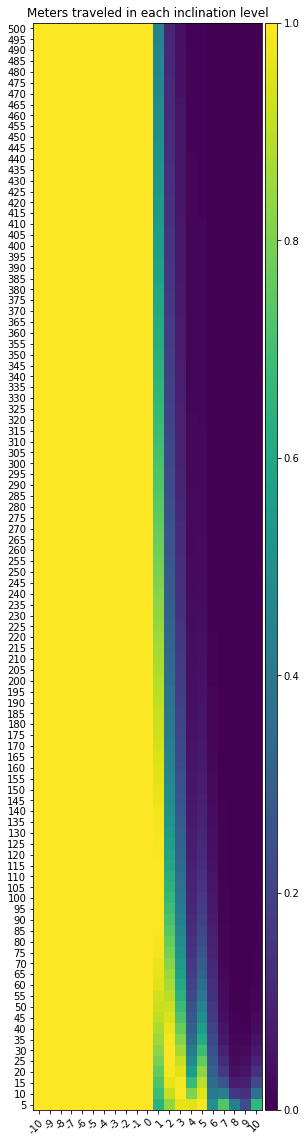

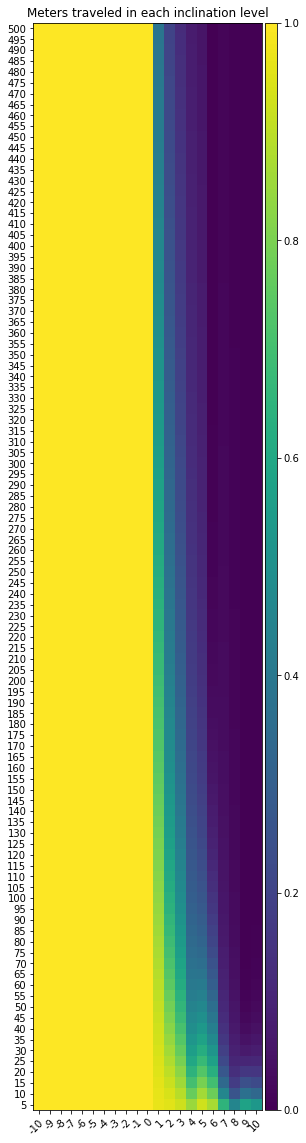

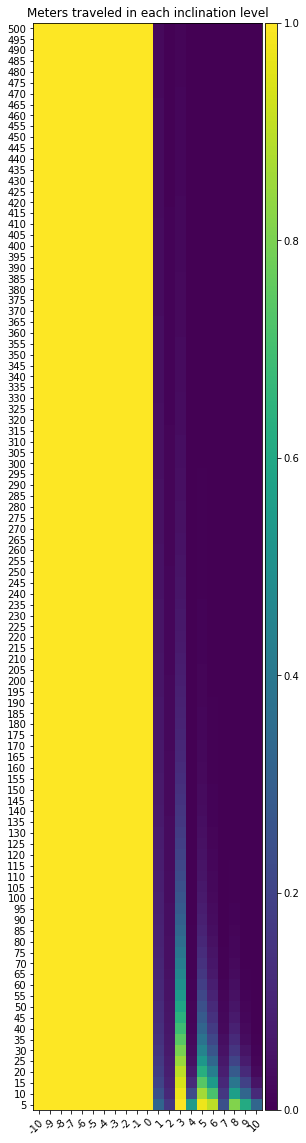

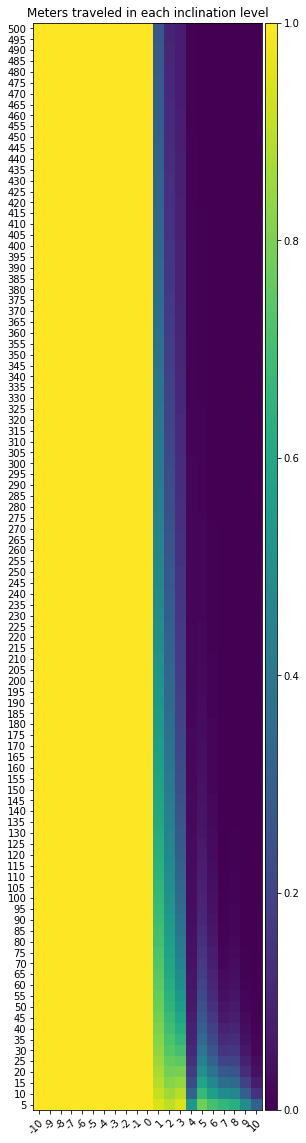

In [27]:

from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_heatmap (values, title):
    fig, ax = plt.subplots(figsize=(10,20))
    im = ax.imshow(1 - values)
    ax.set_xticks(np.arange(len(x)))
    ax.set_yticks(np.arange(len(y)))
    ax.set_xticklabels(x)
    ax.set_yticklabels(y)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    ax.set_title("Meters traveled in each inclination level")
    divider = make_axes_locatable(ax)
    plt.colorbar(im, cax=divider.append_axes("right", size="5%", pad=0.05))
    plt.savefig('./images/' + title)
    plt.show()

plot_heatmap(1 - valuesm, 'male_version_1')
plot_heatmap(valuesm2, 'male_version_2')
plot_heatmap(1 - valuesf, 'female_version_1')
plot_heatmap(valuesf2, 'female_version_2')